In [2]:
import numpy as np
import pandas as pd
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
    (Stepwise,
     sklearn_selected,
     sklearn_selection_path)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

We will apply the forward-selection approach to the Hitters data. wish
to predict a baseball player’s Salary on the basis of various statistic associated with performance in the previous year

In [3]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()
# Checks all values that are missing observations for the 'Salary' variable and sums the number of occurrences (59 in this case)

np.int64(59)

In [4]:
Hitters = Hitters.dropna();
Hitters.shape
# Number of rows and columns
# Removes all rows that have missing values

(263, 20)

In [5]:
# Creating our own function to calculate the Cp statistic of a model

def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    # n = rows (observations), p = columns (predictors)
    n, p = X.shape
    Yhat = estimator.predict(X)
    # Calculates RSS as the sum of differences between estimates and actual observations squared
    RSS = np.sum((Y - Yhat)**2)
    # Returns (-RSS + 2p(sigma2)) / n
    return -(RSS + 2 * p * sigma2) / n

In [6]:
# Drops Salary as a predictor from the dataset Hitters because this is what we are trying to predict
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
# Assigns our dependent variable or response variable to 'Salary"
Y = np.array(Hitters['Salary'])
# Creates a matrix of all predictor variables other than 'Salary'
X = design.transform(Hitters)
# Sets sigma2 to the value of estimated error variance
sigma2 = OLS(Y, X).fit().scale

In [7]:
# This line creates a partial function called neg_Cp where sigma2 is fixed with the value calculated earlier.  This means when we call neg_Cp later on we will only need to specify the three remaining parameters; estimator, X, and Y

neg_Cp = partial(nCp, sigma2)

In [8]:
# Stepwise.first_peak() creates a strategy that will stop at the first peak (local maximum) it finds in the model selection process.

# The parameters used are design (contains all predictor variables except 'Salary'), direction = 'forward' (Specifies that this is forward stepwise selection), and max_terms = len(design.terms) (Sets the maximum number of terms that can be included to the number of available predictors.

strategy = Stepwise.first_peak(design,
                               direction = 'forward',
                               max_terms = len(design.terms))

In [9]:
# Creates a model that combines Ordinary Least Squares regression with the forward stepwise selection and the sklearn_selected function adapts the model to work with scikit-learn's API

hitters_MSE = sklearn_selected(OLS,
                               strategy)

# Fits the model to the data (Hitters contains predictors, and Y contains the target variable ('Salary'))

hitters_MSE.fit(Hitters, Y)

# Displays which variables were selected my forward stepwise when using MSE as the criterion

hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [10]:
# Creates a model that combines Ordinary Least Squares regression with the forward stepwise selection and the sklearn_selected function adapts the model to work with scikit-learn's API

hitters_Cp = sklearn_selected(OLS,
                              strategy,
                              scoring = neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [11]:
strategy  = Stepwise.fixed_steps(design,
                                 len(design.terms),
                                 direction = 'forward',)
full_path = sklearn_selection_path(OLS, strategy)

In [12]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

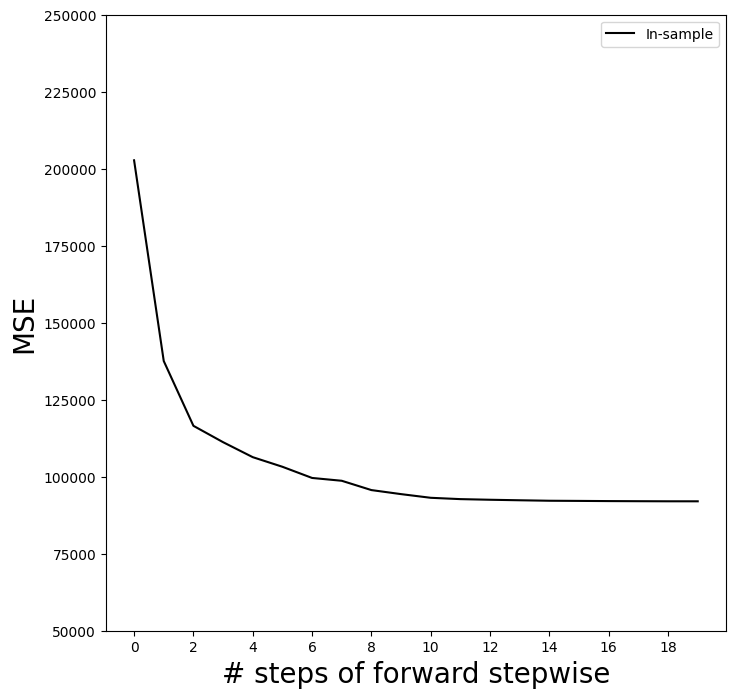

In [13]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

In [14]:
K=5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

In [15]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

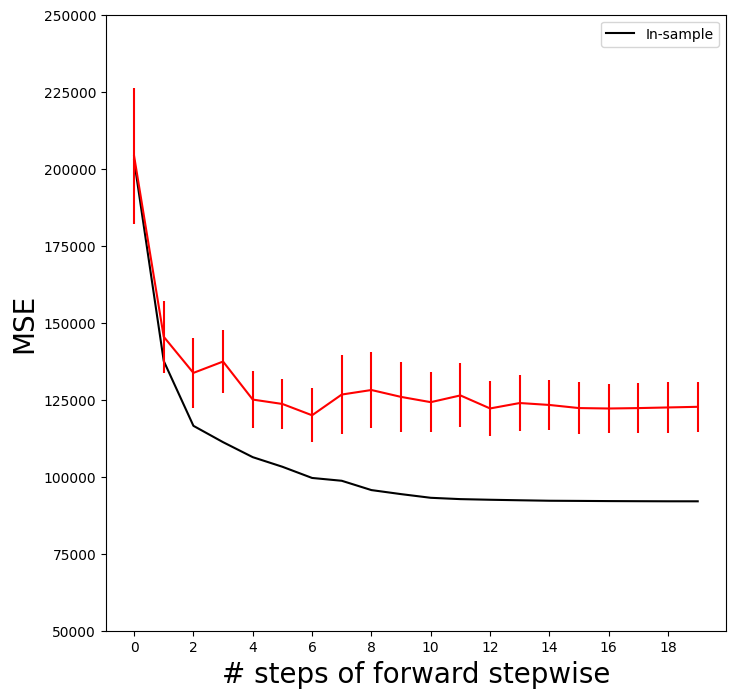

In [16]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            c = 'r') # Color red
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [17]:
validation = skm.ShuffleSplit(n_splits = 1,
                              test_size = 0.2,
                              random_state = 0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                  Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    validation_mse = errors.mean(0)

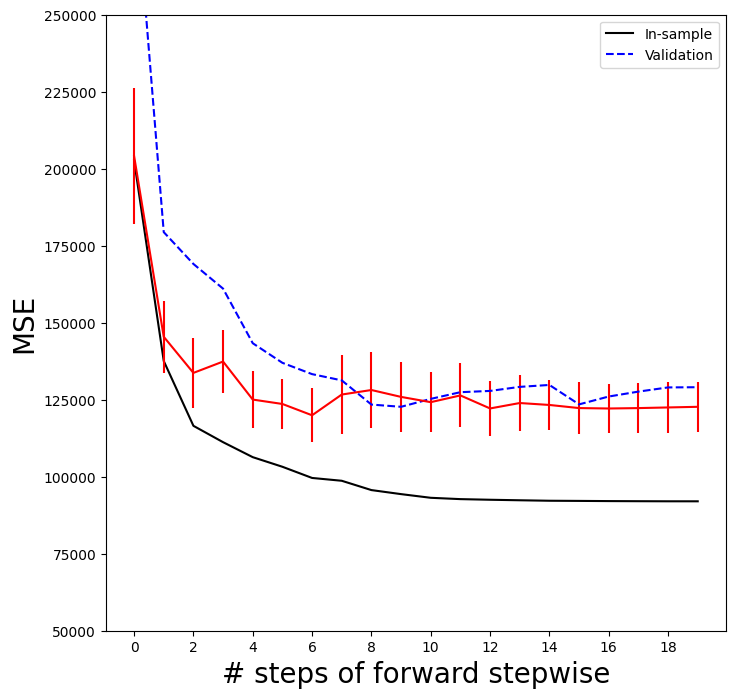

In [18]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # Color blue, broken line
        label = 'Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [19]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis = 1)
X = np.asarray(D)

In [1]:
!pip install l0bnb
from l0bnb import fit_path